In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd 
import os
import torch
import scanpy as sc 

import sys
sys.path.append('../src')

embedding_dir = '/ix/djishnu/alw399/SLIDE_PLM/data/pjm_models/embeddings/15epochs'

/ix3/djishnu/alw399/envs/tiger/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ix3/djishnu/alw399/envs/tiger/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ix3/djishnu/alw399/envs/tiger/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ix3/djishnu/alw399/envs/tiger/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ix3/djishnu/alw399/envs/tiger/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `

In [ ]:
# # CLONAL EXPANSION
# name = 'jing_clonal_expansion'
# n_pcs = 16
# model_name = f'pjm_15epochs_pca{n_pcs}'
# y_path = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_Yexpanded_filtered85.csv'
# slide_outs = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/KIR+TEDDY_filtered85/KIR+TEDDY_filtered85_noint_output/0.01_0.5_out'
# y = pd.read_csv(y_path)['Y'].values
# sequences = pd.read_csv('/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_betaseqs_raw.csv', index_col=0)

# # JING TUMOR
# name = 'jing_tumor'
# n_pcs = 16
# model_name = f'pjm_15epochs_pca{n_pcs}'
# y_path = '/ix/djishnu/alw399/SLIDE_PLM/data/jing_tumor/tumor_y2.csv'
# slide_outs = '/ix/djishnu/alw399/SLIDE_PLM/data/jing_tumor/0.05_0.5_out'
# y = pd.read_csv(y_path)['y'].values
# sequences = pd.read_csv('/ix/djishnu/alw399/SLIDE_PLM/data/jing_tumor/filtered_x2_cdr3_b.csv')

# # ANTIGEN SPECIFICITY
# name = 'alok_antigen_specificity'
# n_pcs = 16
# model_name = f'pjm_15epochs_pca{n_pcs}'
# slide_outs = '/ix/djishnu/Jane/SLIDESWING/alok_data/alok_data12_MRfilt_noint_out/0.01_2_out'
# x_path = '/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_rna_MRfilt_forSLIDE.csv'
# y_path = '/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_rna_MRfilt_antigens.csv' 
# y = pd.read_csv(y_path)['Antigen'].values - 1
# sequences = pd.read_csv('/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_seqs.csv', index_col=0)['beta']

# # CONGA c2_gex_donor2
# name = 'conga_c2_gex_donor2'
# n_pcs = 16
# model_name = f'pjm_15epochs_pca{n_pcs}'
# y_path = '/ix/djishnu/alw399/SLIDE_PLM/data/conga/slide/inputs/c2gex_donor2_y.csv'
# slide_outs = '/ix/djishnu/alw399/SLIDE_PLM/data/conga/slide/outputs/c2gex_donor2/0.1_1_out'
# y = pd.read_csv(y_path)['is_c2'].values
# adata = sc.read_h5ad('/ix/djishnu/alw399/SLIDE_PLM/data/conga/paper_data/10x_200k/donor2/donor2_conga.h5ad')
# sequences = adata.obs['cdr3b']

# # MAIT donor2
# name = 'conga_mait_donor2'
# n_pcs = 16
# model_name = f'pjm_15epochs_pca{n_pcs}'
# y_path = f'/ix/djishnu/alw399/SLIDE_PLM/data/conga/slide/inputs/mait_donor2_y.csv'
# slide_outs = '/ix/djishnu/alw399/SLIDE_PLM/data/conga/slide/outputs/mait_donor2/0.01_0.5_out'
# y = pd.read_csv(y_path)['is_mait'].values
# sequences = sc.read_h5ad('/ix/djishnu/alw399/SLIDE_PLM/data/conga/paper_data/10x_200k/donor2/donor2_conga.h5ad').obs['cdr3b']


In [58]:
# CONGA CELLS SUBSETS

# # CONGA c2_gex_donor2
# name = 'conga_c2_gex_donor2'
# n_pcs = 16
# model_name = f'pjm_15epochs_pca{n_pcs}_congacells'
# y_path = '/ix/djishnu/alw399/SLIDE_PLM/data/conga/slide/inputs/c2gex_donor2_y.csv'
# slide_outs = '/ix/djishnu/alw399/SLIDE_PLM/data/conga/slide/outputs/c2gex_donor2/0.1_1_out'
# y = pd.read_csv(y_path)['is_c2'].values
# conga_adata = sc.read_h5ad('/ix/djishnu/alw399/SLIDE_PLM/data/conga/paper_data/10x_200k/donor2/donor2_conga.h5ad')
# sequences = conga_adata.obs['cdr3b']

# MAIT donor2
name = 'conga_mait_donor2'
n_pcs = 16
model_name = f'pjm_15epochs_pca{n_pcs}_congacells'
y_path = f'/ix/djishnu/alw399/SLIDE_PLM/data/conga/slide/inputs/mait_donor2_y.csv'
slide_outs = '/ix/djishnu/alw399/SLIDE_PLM/data/conga/slide/outputs/mait_donor2/0.01_0.5_out'
y = pd.read_csv(y_path)['is_mait'].values
conga_adata = sc.read_h5ad('/ix/djishnu/alw399/SLIDE_PLM/data/conga/paper_data/10x_200k/donor2/donor2_conga.h5ad')
sequences = conga_adata.obs['cdr3b']

In [59]:
from util import get_sigLFs

z1s = get_sigLFs(slide_outs)
z_matrix = pd.read_csv(os.path.join(slide_outs, 'z_matrix.csv'), index_col=0)
z_matrix = z_matrix[z1s]
z_matrix.shape

(6495, 68)

In [60]:
# Interactors did not contribute to signal
# z_matrix = pd.DataFrame(z_matrix['Z7'])
z_matrix = pd.DataFrame(z_matrix['Z79'])

In [61]:
conga_cells = conga_adata.obs['conga_scores'] <= 1

sequences = sequences[conga_cells]
y = y[conga_cells]
z_matrix = z_matrix[conga_cells]

In [62]:
from util import remove_empty_tcrs

sequences, y, z_matrix = remove_empty_tcrs(sequences, y, z_matrix)
sequences.shape, y.shape, z_matrix.shape

((599,), (599,), (599, 1))

### Get embeddings from pjm model

In [ ]:
from pjm.pjm import from_pretrained, build_default_alphabet

alphabet = build_default_alphabet()

# Load encoder
embedder = from_pretrained(
    model_type="mmplm",
    alphabet=alphabet,
    checkpoint_path='/ix/djishnu/alw399/SLIDE_PLM/data/pjm_models/mmplm_15epochs_dim256_ckpt.pth',
)

In [ ]:
tokenizer = alphabet.get_batch_converter()

batch_labels = sequences.astype(str)
seq_str_list = sequences.astype(str)
raw_batch = list(zip(batch_labels, seq_str_list))

labels, strs, tokens = tokenizer(raw_batch)

In [ ]:
embeddings = embedder(tokens)
embeddings.shape

In [ ]:
np.save(os.path.join(embedding_dir, f'{name}.npy'), embeddings.detach().numpy())

### Run interactions

In [63]:
embeddings = np.load(os.path.join(embedding_dir, f'{name}.npy'))
embeddings = embeddings.reshape(embeddings.shape[0], -1)
embeddings.shape

(6495, 7168)

In [64]:
embeddings = embeddings[conga_cells]

In [65]:
from sklearn.decomposition import PCA

model = PCA(n_components=n_pcs)
model.fit(embeddings)
tcr_embeddings = model.transform(embeddings)
tcr_embeddings.shape

(599, 16)

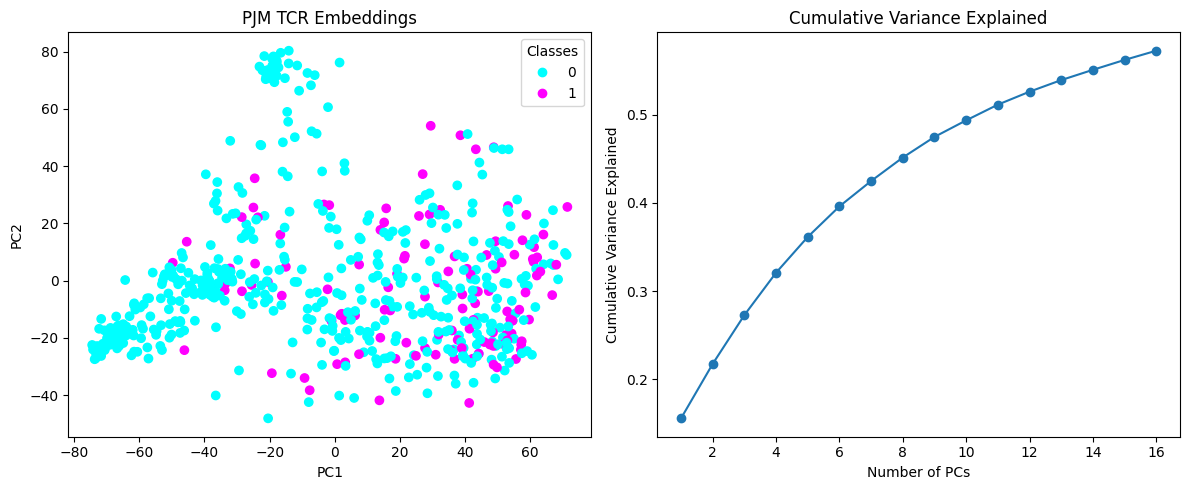

In [66]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot
scatter = ax[0].scatter(tcr_embeddings[:, 0], tcr_embeddings[:, 1], c=y, cmap='cool')
legend1 = ax[0].legend(*scatter.legend_elements(), title="Classes")
ax[0].set_title('PJM TCR Embeddings')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

# Cumulative variance explained plot
cumsum_variance = np.cumsum(model.explained_variance_ratio_)
ax[1].plot(range(1, n_pcs+1), cumsum_variance, marker='o')
ax[1].set_title('Cumulative Variance Explained')
ax[1].set_xlabel('Number of PCs')
ax[1].set_ylabel('Cumulative Variance Explained')

plt.tight_layout()
os.makedirs(f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}', exist_ok=True)
plt.savefig(f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_pca.png')
plt.show()


In [67]:
from interaction import Interaction

machop = Interaction(
    slide_outs, 
    plm_embed=tcr_embeddings, 
    y=y,
    z_matrix=z_matrix,
    interacts_only=False,
    model='LR'
)

In [68]:
fdr = 0.4
thresh = 0.65

machop.get_sig_interactions(fdr=fdr, n_iters=20, thresh=thresh)

Found 4 significant interactions with AUC=0.9323119491699118


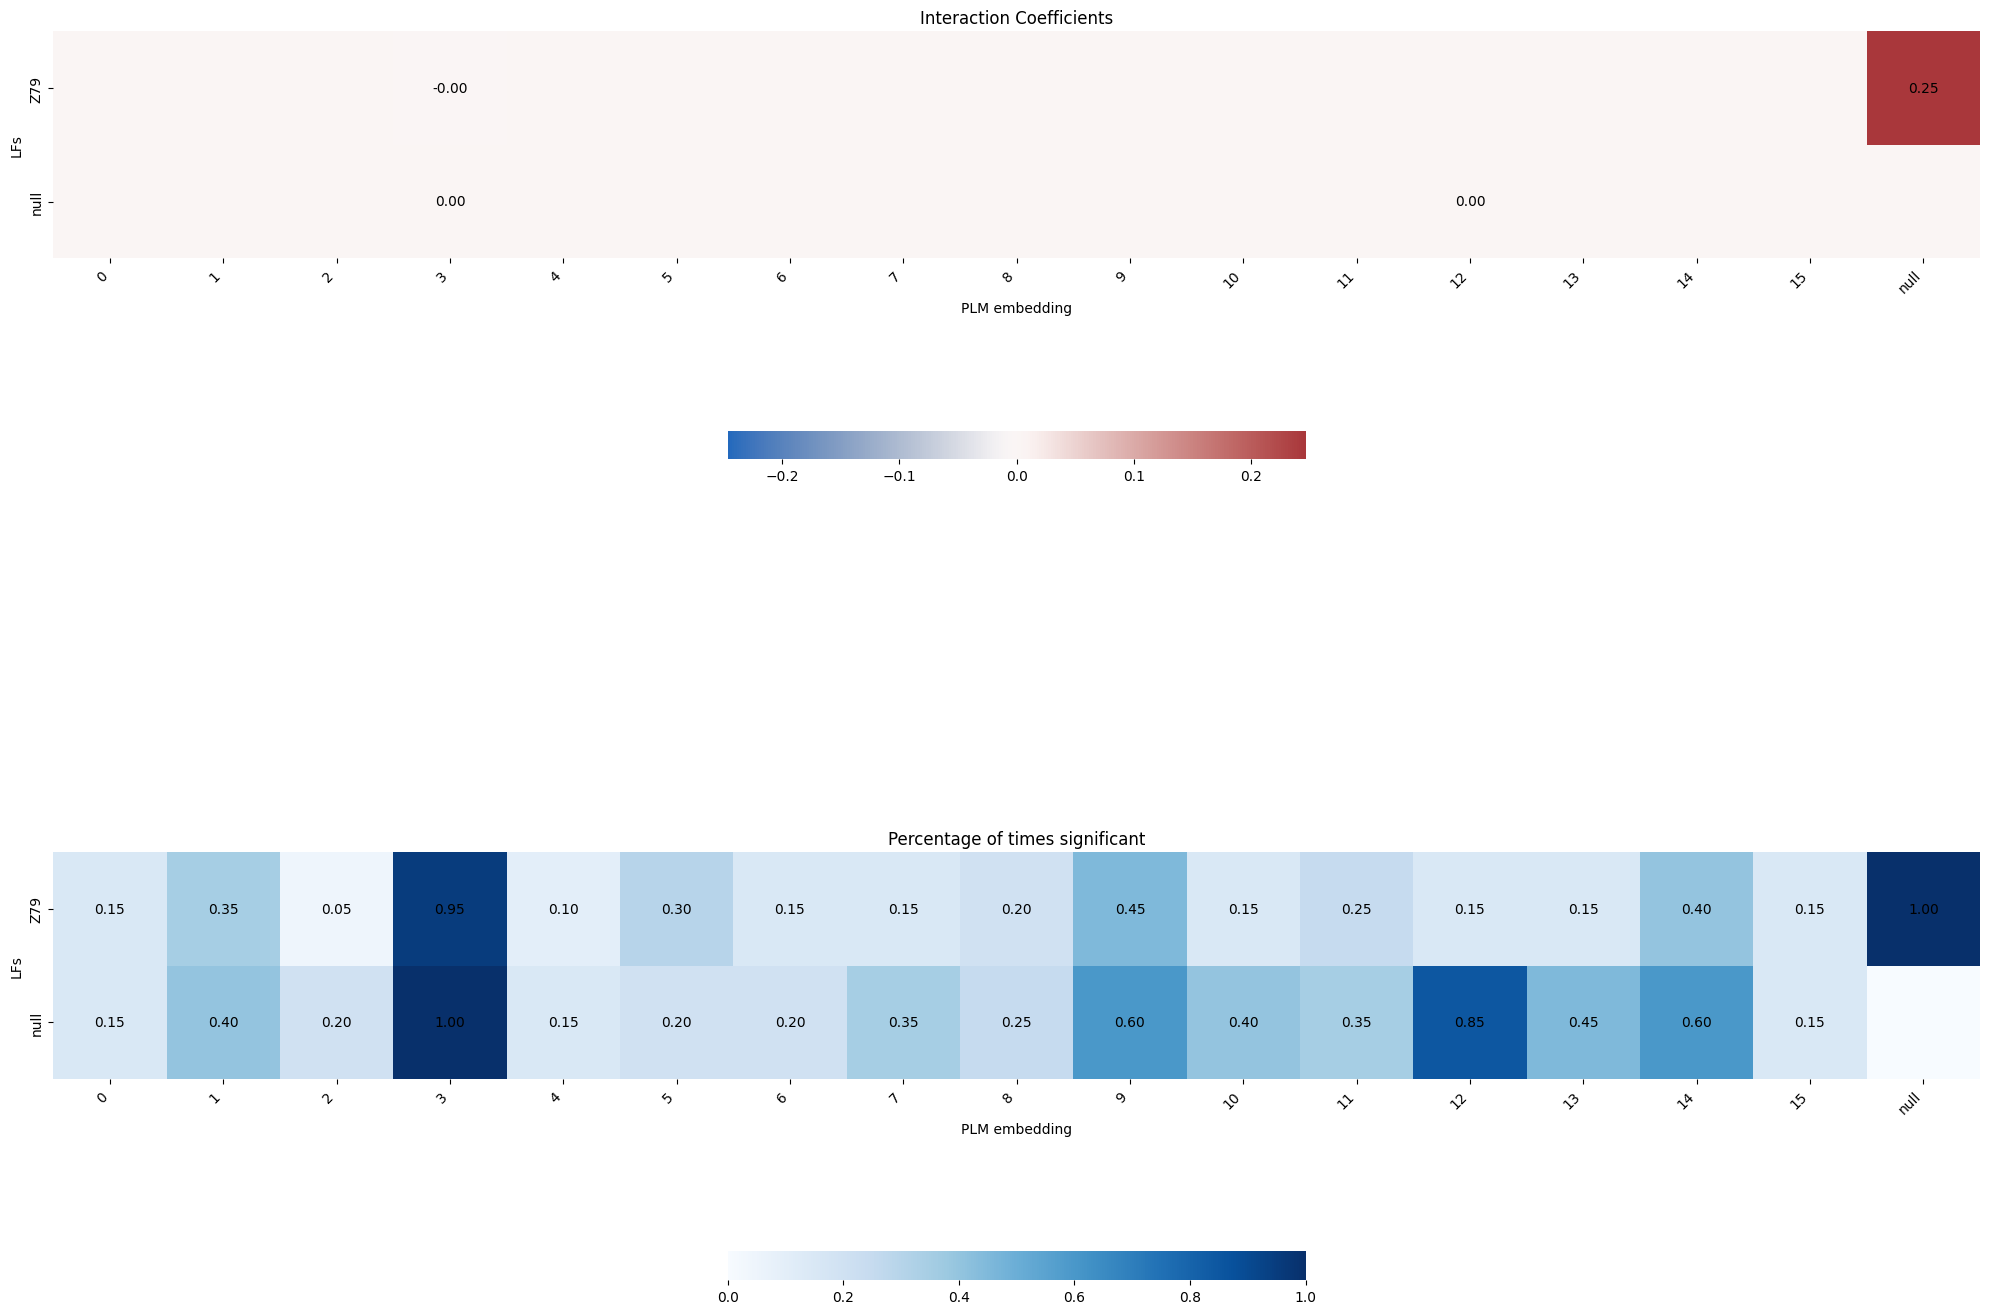

In [69]:
from plotting import show_interactions
show_interactions(machop, save_path=f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_betas_fdr{fdr}_thresh{thresh}.png')

In [70]:
machop.get_joint_embed()
joint_embed = machop.joint_embed.copy()
joint_embed.shape

(599, 4)

In [71]:
thresh = machop.params['thresh']
fdr = machop.params['fdr']
n_iters = machop.params['n_iters']

np.save(f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_joint_embed_fdr{fdr}_iters{n_iters}_thresh_{thresh}.npy', joint_embed)

In [72]:
full_embed = np.hstack([machop.z_matrix, machop.plm_embedding])
full_embed.shape

(599, 19)

In [73]:
from models import Estimator
from sklearn.linear_model import Lasso, LinearRegression

model = Lasso(alpha=0.02)

In [74]:
estimator = Estimator(model=model)
auc0 = estimator.evaluate(joint_embed, y)
auc1 = estimator.evaluate(full_embed, y)
auc2 = estimator.evaluate(machop.z_matrix, y)
auc3 = estimator.evaluate(machop.plm_embedding, y)

In [75]:
df = pd.DataFrame(
    np.vstack([auc0, auc1, auc2, auc3]),
    index=['joint', 'full', 'z-matrix', 'plm']
)
df.reset_index(inplace=True)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

joint vs. plm: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.381e-05 Stat=1.631e+01
plm vs. z-matrix: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.381e-05 Stat=1.631e+01
full vs. plm: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.381e-05 Stat=1.631e+01


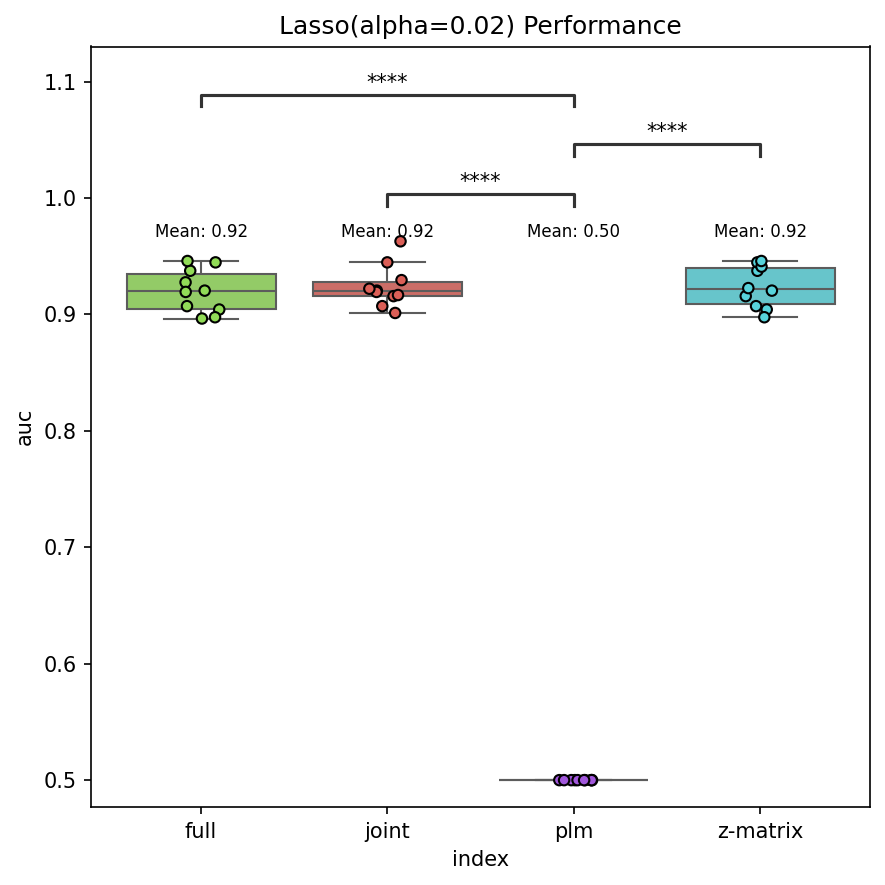

In [76]:
from plotting import show_performance
show_performance(model, df, 
                 save_path=f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_{model.__class__.__name__}_performance_fdr{fdr}_thresh{thresh}.png')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

joint vs. plm: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.571e-04 Stat=1.429e+01
plm vs. z-matrix: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.571e-04 Stat=1.429e+01
full vs. plm: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.571e-04 Stat=1.429e+01


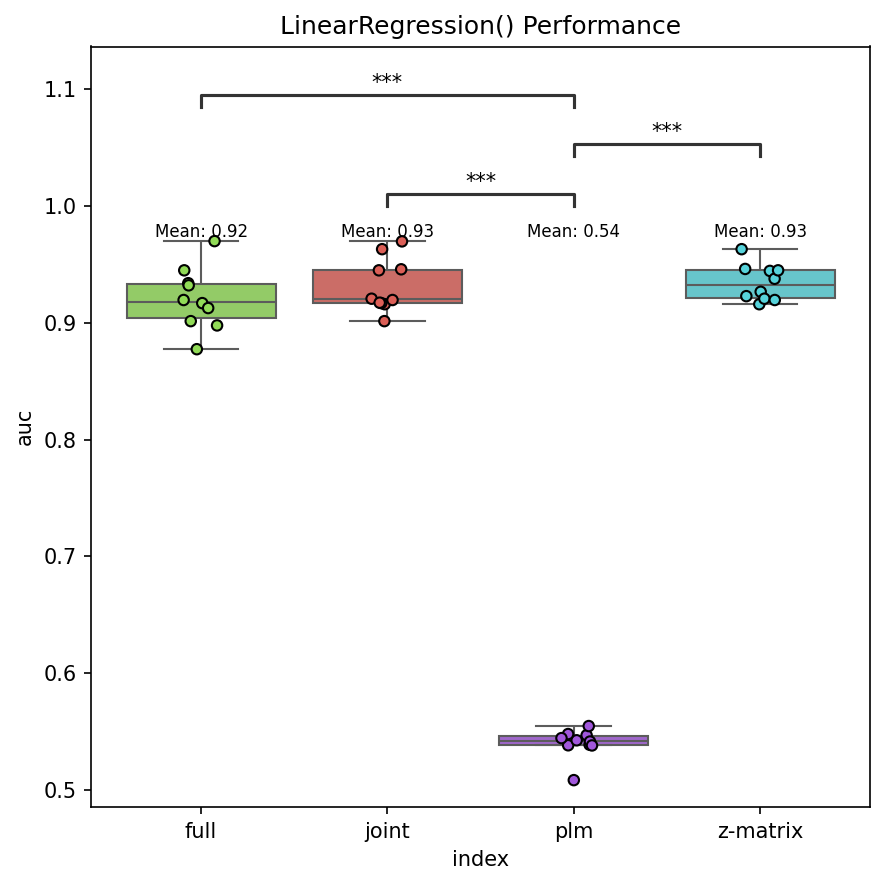

In [77]:
model = LinearRegression()

estimator = Estimator(model=model)
auc0 = estimator.evaluate(joint_embed, y)
auc1 = estimator.evaluate(full_embed, y)
auc2 = estimator.evaluate(machop.z_matrix, y)
auc3 = estimator.evaluate(machop.plm_embedding, y)

df = pd.DataFrame(
    np.vstack([auc0, auc1, auc2, auc3]),
    index=['joint', 'full', 'z-matrix', 'plm']
)
df.reset_index(inplace=True)

show_performance(
    model, df, 
    save_path=f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_{model.__class__.__name__}_performance_fdr{fdr}_thresh{thresh}.png'
)

### Compare CONGA

In [ ]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)

In [ ]:
fdr = 0.2
thresh = 0.8
n_iters = 20

# Use joint_embedding
joint_embed = np.load(f'/ix/djishnu/alw399/SLIDE_PLM/results/plm/{name}/{model_name}_joint_embed_fdr{fdr}_iters{n_iters}_thresh_{thresh}.npy')
joint_embed.shape

In [ ]:
adata.obs['clusters_gex'] = adata.obs['clusters_gex'].astype('category')
adata.obs['clusters_tcr'] = adata.obs['clusters_tcr'].astype('category')
adata.obs['conga_scores_significant'] = np.where(adata.obs['conga_scores'] <= 1, 1, 0)

adata.obsm['X_umap'] = adata.obsm['X_umap_gex']
sc.pl.umap(adata, color=['conga_scores_significant', 'clusters_gex', 'clusters_tcr'])

In [ ]:
adata.obsm['X_umap'] = adata.obsm['X_umap_tcr']
sc.pl.umap(adata, color=['conga_scores_significant', 'clusters_gex', 'clusters_tcr'])

In [ ]:
embed_data = sc.AnnData(joint_embed)
embed_data.obs['y'] = y
embed_data.obs['y'] = embed_data.obs['y'].astype('category')

embed_data.obs['conga_gex_clusters'] = adata.obs['clusters_gex'].values
embed_data.obs['conga_gex_clusters'] = embed_data.obs['conga_gex_clusters'].astype('category')
embed_data.obs['conga_scores'] = adata.obs['conga_scores'].values
embed_data.obs['conga_scores_significant'] = adata.obs['conga_scores_significant'].values

sc.pp.neighbors(embed_data)
sc.tl.pca(embed_data)
sc.tl.umap(embed_data)
sc.tl.leiden(embed_data)

In [ ]:
from tqdm import tqdm
from models import Estimator
from sklearn.linear_model import Lasso, LinearRegression

performance = {}
model = LinearRegression()
estimator = Estimator(model=model)


for cluster in tqdm(embed_data.obs['conga_gex_clusters'].unique()):

    cluster_data = embed_data[embed_data.obs['conga_gex_clusters'] != cluster]

    y_cluster = cluster_data.obs['y'].values
    X_cluster = cluster_data.X

    auc = estimator.evaluate(X_cluster, y_cluster, n_iters=30)
    performance[cluster] = auc

In [ ]:
aucs = pd.DataFrame(performance).T
aucs.rename(columns={i: f'iter_{i}' for i in range(len(aucs.columns))}, inplace=True)
aucs['mean'] = aucs.mean(axis=1, skipna=True)
aucs['std'] = aucs.std(axis=1, skipna=True)
aucs.sort_values('mean')

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

# aucs.drop(columns=['mean', 'std'], inplace=True)
df = aucs.melt(id_vars='index', var_name='iter', value_name='auc')

fig, ax = plt.subplots(figsize=(10,4), dpi=150)
order = np.unique(df['index'])

sns.boxplot(data=df, x='index', y='auc', hue='index', palette='hls', ax=ax, legend=False, showfliers=False, order=order)
sns.stripplot(data=df, x='index', y='auc', hue='index', ax=ax, palette='hls', legend=False, linewidth=1, edgecolor='black', jitter=True)
ax.set_xlabel('cluster')
plt.title('Linear Regression with Joint Embedding when CONGA Cluster is Omitted')


In [ ]:
sc.pl.pca(embed_data, color=['y', 'leiden', 'conga_gex_clusters', 'conga_scores_significant'])
sc.pl.umap(embed_data, color=['y', 'leiden', 'conga_gex_clusters', 'conga_scores_significant'])

In [ ]:
import matplotlib.pyplot as plt

n_plots = (joint_embed.shape[1] + 1) // 2
n_rows = (n_plots + 2 - 1) // 2 

fig, axs = plt.subplots(2, n_rows, figsize=(20, n_rows * 4)) 
axs = axs.flatten()

for i in range(0, joint_embed.shape[1], 2):
    dim1 = joint_embed[:, i]
    dim2 = joint_embed[:, i+1] if i+1 < joint_embed.shape[1] else joint_embed[:, i-1] 
    
    axs[i//2].scatter(dim1, dim2, c=y, alpha=0.5, cmap='coolwarm', s=2)
    axs[i//2].set_xlabel(f'joint embed {i}')
    axs[i//2].set_ylabel(f'joint embed {i+1}' if i+1 < joint_embed.shape[1] else f'joint embed {i-1}')

plt.suptitle('Separation of classes using joint embedding from Daniel\'s model', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()
